In [3]:
%load_ext autoreload
%autoreload 2

# To load the environment variable defined in the .env file
from dotenv import load_dotenv
load_dotenv();

import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from scipy import ndimage
from scipy import stats
from scipy.ndimage import gaussian_filter 
from sklearn.neighbors import KernelDensity
import seaborn as sns

In [4]:
season_year = 2017
season_type = "Regular"

In [5]:
import src.data.NHLDataManager as DataManager
data_manager = DataManager.NHLDataManager()
data = data_manager.load_data(season_year=season_year, season_type=season_type)

  0%|          | 0/1271 [00:00<?, ?it/s]

In [6]:
game_numbers = data_manager.get_game_numbers(season_year=season_year, season_type=season_type)
data_season_df = data_manager.get_goals_and_shots_df(season_year=season_year, season_type=season_type, game_number=game_numbers[0])

for game_number in game_numbers[1:]:
    data_season_df = pd.concat([data_season_df, data_manager.get_goals_and_shots_df(season_year=season_year, season_type=season_type, game_number=game_number)])


In [7]:
data_season_df

,Game ID,Event Index,Time,Period,Team,Type,Shot Type,Shooter,Goalie,Empty Net,Strength,X,Y
0,2017020001,93,15:45,1,Toronto Maple Leafs (TOR),GOAL,Wrist Shot,Nazem Kadri,Steve Mason,False,Power Play,84.0,-6.0
1,2017020001,108,17:40,1,Toronto Maple Leafs (TOR),GOAL,Wrist Shot,James van Riemsdyk,Steve Mason,False,Even,62.0,5.0
2,2017020001,112,18:23,1,Toronto Maple Leafs (TOR),GOAL,Wrist Shot,William Nylander,Steve Mason,False,Even,84.0,-22.0
3,2017020001,157,08:32,2,Toronto Maple Leafs (TOR),GOAL,Backhand,Patrick Marleau,Steve Mason,False,Even,-82.0,2.0
4,2017020001,225,00:36,3,Toronto Maple Leafs (TOR),GOAL,Wrist Shot,Patrick Marleau,Steve Mason,False,Even,68.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49,2017021271,274,16:11,3,San Jose Sharks (SJS),SHOT,Snap Shot,Joe Pavelski,Devan Dubnyk,NaN,NaN,82.0,8.0
50,2017021271,279,16:59,3,San Jose Sharks (SJS),SHOT,Snap Shot,Evander Kane,Devan Dubnyk,NaN,NaN,34.0,-30.0
51,2017021271,281,18:10,3,San Jose Sharks (SJS),SHOT,Snap Shot,Timo Meier,Devan Dubnyk,NaN,NaN,52.0,35.0
52,2017021271,288,19:22,3,San Jose Sharks (SJS),SHOT,Snap Shot,Brent Burns,Devan Dubnyk,NaN,NaN,31.0,-16.0


In [8]:
total_shots_league = len(data_season_df)
number_of_games = len(data_season_df['Game ID'].unique())
print(f'Total number of shots during season {season_year} ({season_type}) = {total_shots_league}')
print(f'Number of games during season {season_year} ({season_type}) = {number_of_games}')

mean_shots_per_hour = total_shots_league / number_of_games
print(f'Mean shots per hour during season {season_year} ({season_type}) = {mean_shots_per_hour}')

total_goals_league = len(data_season_df[data_season_df['Type'] == 'GOAL'])
mean_goals_per_hour = total_goals_league / number_of_games
print(f'Mean goals per hour during season {season_year} ({season_type}) = {mean_goals_per_hour}')


Total number of shots during season 2017 (Regular) = 81873
Number of games during season 2017 (Regular) = 1271
Mean shots per hour during season 2017 (Regular) = 64.4162077104642
Mean goals per hour during season 2017 (Regular) = 6.051140833988985


In [9]:
list_of_teams = data_season_df['Team'].unique()
number_of_teams = len(list_of_teams)

print(f'Number of Teams during season {season_year} ({season_type}) = {number_of_teams}')

Number of Teams during season 2017 (Regular) = 31


In [10]:
data_season_df[['Team', 'Type', 'X', 'Y', 'Period', 'Game ID']].head(15)
print(data_season_df.columns)

Index(['Game ID', 'Event Index', 'Time', 'Period', 'Team', 'Type', 'Shot Type',
       'Shooter', 'Goalie', 'Empty Net', 'Strength', 'X', 'Y'],
      dtype='object')


In [84]:
df_total_shots_per_team = data_season_df[['Team', 'Type', 'X', 'Y']].dropna().groupby('Team').size()
df_mean_shots_per_team_per_hour = df_total_shots_per_team / 82.
print(df_mean_shots_per_team_per_hour.sample(20))

Team
Winnipeg Jets (WPG)          32.475610
Edmonton Oilers (EDM)        33.609756
Boston Bruins (BOS)          33.195122
Nashville Predators (NSH)    32.597561
Los Angeles Kings (LAK)      31.134146
Pittsburgh Penguins (PIT)    34.536585
Colorado Avalanche (COL)     29.743902
Montréal Canadiens (MTL)     33.048780
Chicago Blackhawks (CHI)     34.207317
Calgary Flames (CGY)         33.865854
New York Rangers (NYR)       31.243902
Buffalo Sabres (BUF)         31.280488
Florida Panthers (FLA)       34.634146
Vancouver Canucks (VAN)      30.317073
Arizona Coyotes (ARI)        30.146341
Tampa Bay Lightning (TBL)    32.878049
Dallas Stars (DAL)           31.451220
Washington Capitals (WSH)    29.121951
New Jersey Devils (NJD)      32.048780
New York Islanders (NYI)     31.548780
dtype: float64


In [12]:
def convert_shots_to_offensize_zone(x_shots, y_shots):

   # Shots taken from behind the goal is from the defensive zone.
   # Since we are only interested in shots taken in the offensive zone, we skip them
   shots_defzone_mask = (x_shots < -89) | (x_shots > 89)
   x_shots = x_shots[~shots_defzone_mask] 
   y_shots = y_shots[~shots_defzone_mask]

   # Flip the y coordinates if x is negative
   shots_xneg_mask = x_shots < 0
   x_shots = abs(x_shots)
   y_shots[shots_xneg_mask] = -y_shots[shots_xneg_mask] 

   # Reverse the x axis, so the goal is at 0
   x_shots = 89 - x_shots

   return [x_shots, y_shots]

In [13]:
x_shots_season = data_season_df['X'].dropna().to_numpy().copy().astype(np.float32)
y_shots_season = data_season_df['Y'].dropna().to_numpy().copy().astype(np.float32)

[x_shots_season, y_shots_season] = convert_shots_to_offensize_zone(x_shots_season, y_shots_season)

number_of_games = len(data_season_df['Game ID'].unique())
print(number_of_games)

#print(x_shots_season.__len__())

1271


In [91]:
data_one_team_df = data_season_df.loc[data_season_df['Team'] == "Tampa Bay Lightning (TBL)"]

df_total_shots_one_team = data_one_team_df[['Team', 'Type', 'X', 'Y']].dropna()

x_shots_one_team = df_total_shots_one_team['X'].dropna().to_numpy().copy().astype(np.float32)
y_shots_one_team = df_total_shots_one_team['Y'].dropna().to_numpy().copy().astype(np.float32)

[x_shots_one_team, y_shots_one_team] = convert_shots_to_offensize_zone(x_shots_one_team, y_shots_one_team)

len(x_shots_one_team)


2690

In [148]:
def get_shots_hist2D(x_shots, y_shots, num_pts=20):

    x_min, x_max = 0.0, 89.0
    y_min, y_max = -42.5, 42.5

    x_grid = np.linspace(x_min, x_max, num_pts+1)
    y_grid = np.linspace(y_min, y_max, num_pts+1)

    ret = stats.binned_statistic_2d(x_shots.tolist(), y_shots.tolist(), None, 'count', bins=[x_grid.tolist(), y_grid.tolist()])

    x_bins = (0.5 * (x_grid[1:] + x_grid[0:-1]))
    y_bins = (0.5 * (y_grid[1:] + y_grid[0:-1]))

    return  ret.statistic, x_bins, y_bins


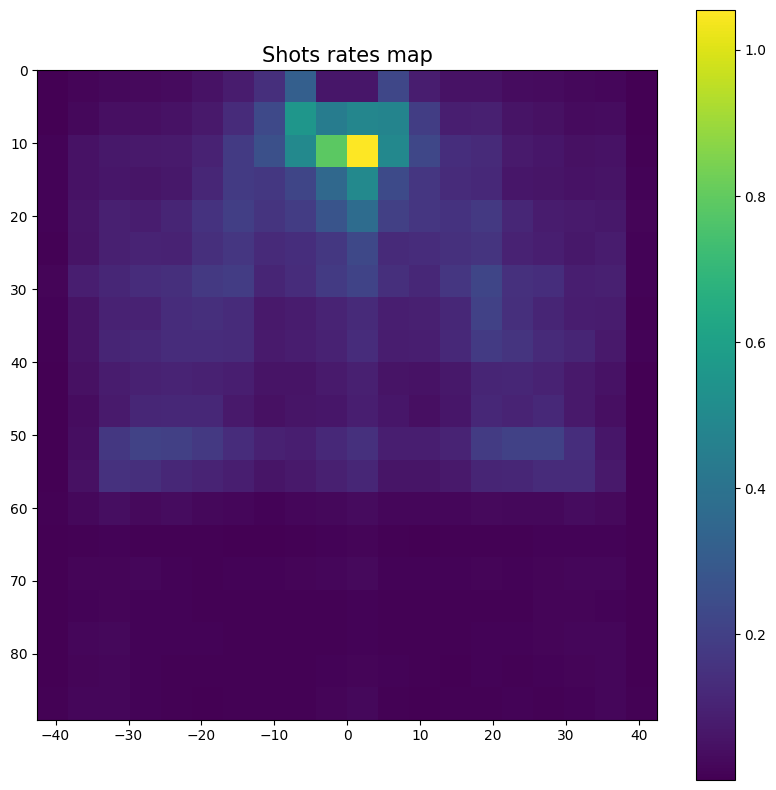

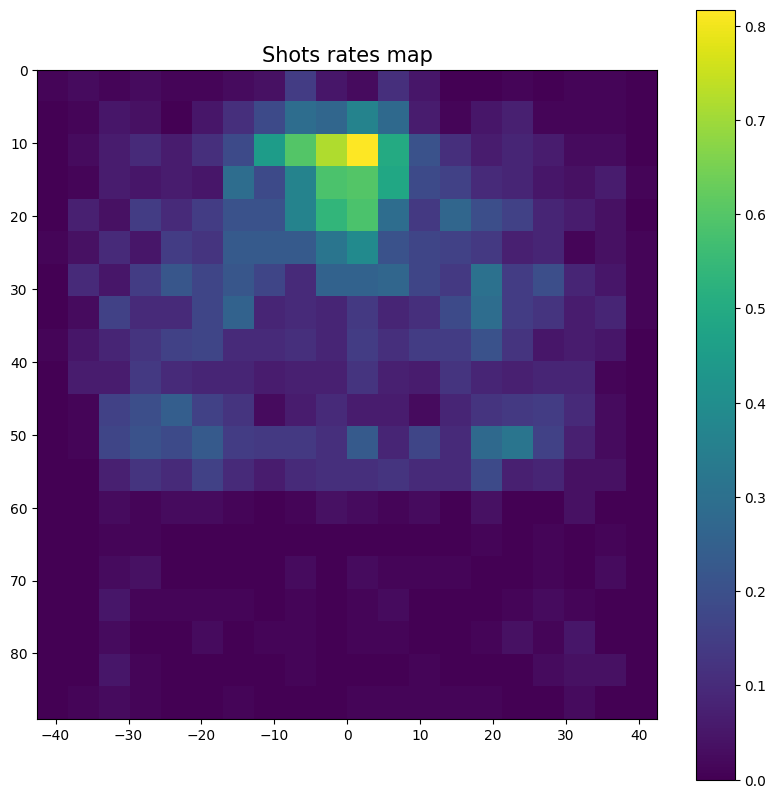

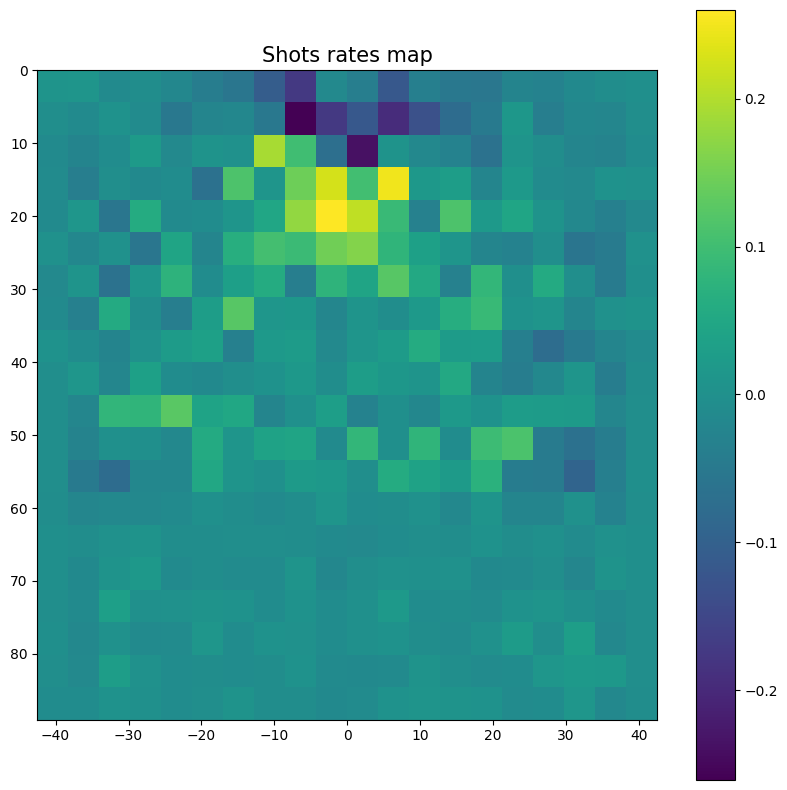

In [117]:
shots_hist2D_season, _, _ = get_shots_hist2D(x_shots_season, y_shots_season, num_pts=20)
shots_hist2D_season_per_hour = shots_hist2D_season / (number_of_games*2)

shots_hist2D_one_team, _, _ = get_shots_hist2D(x_shots_one_team, y_shots_one_team, num_pts=20)

shots_hist2D_one_team_per_hour = shots_hist2D_one_team / 82

fig = plt.figure(figsize=(10,10))
plt.imshow(shots_hist2D_season_per_hour, extent=[-42.5, 42.5, 89, 0])
plt.colorbar(orientation = 'vertical', pad = 0.05)
plt.title('Shots rates map',fontdict={'fontsize': 15})
plt.show()

fig = plt.figure(figsize=(10,10))
plt.imshow(shots_hist2D_one_team_per_hour, extent=[-42.5, 42.5, 89, 0])
plt.colorbar(orientation = 'vertical', pad = 0.05)
plt.title('Shots rates map',fontdict={'fontsize': 15})
plt.show()


fig = plt.figure(figsize=(10,10))
plt.imshow(shots_hist2D_one_team_per_hour-shots_hist2D_season_per_hour, extent=[-42.5, 42.5, 89, 0])
plt.colorbar(orientation = 'vertical', pad = 0.05)
plt.title('Shots rates map',fontdict={'fontsize': 15})
plt.show()


/tmp/ipykernel_2176/2549421535.py:7: RuntimeWarning: invalid value encountered in divide
  diff = (shots_hist2D_one_team_per_hour-shots_hist2D_season_per_hour) / shots_hist2D_season_per_hour


nan


ValueError: Axis limits cannot be NaN or Inf

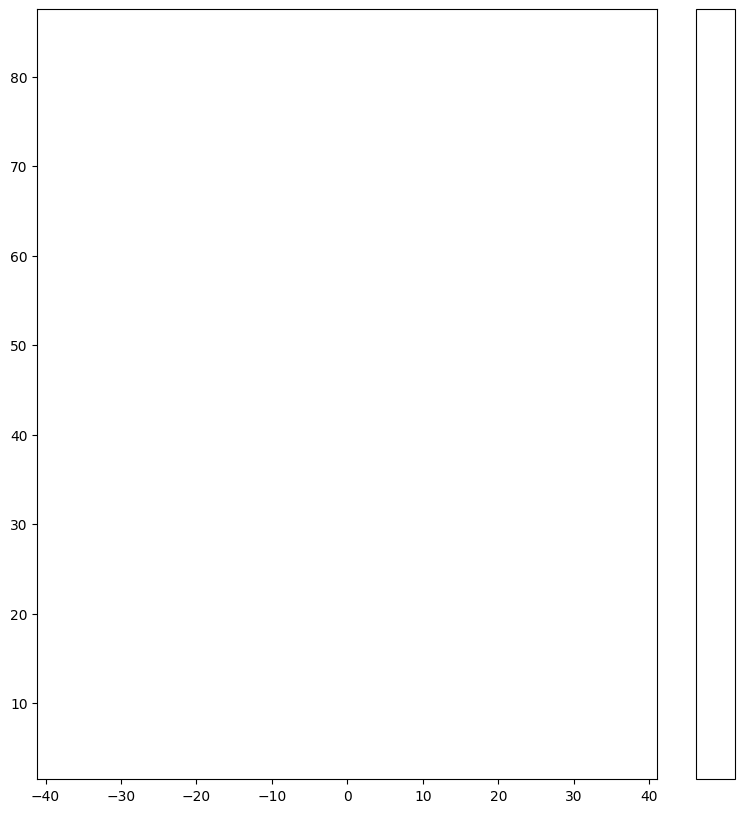

In [157]:
shots_hist2D_season, x_grid, y_grid = get_shots_hist2D(x_shots_season, y_shots_season, num_pts=30)
shots_hist2D_season_per_hour = shots_hist2D_season / (number_of_games*2)

shots_hist2D_one_team, x_grid, y_grid = get_shots_hist2D(x_shots_one_team, y_shots_one_team, num_pts=30)
shots_hist2D_one_team_per_hour = shots_hist2D_one_team / 82

diff = (shots_hist2D_one_team_per_hour-shots_hist2D_season_per_hour) / shots_hist2D_season_per_hour
diff = gaussian_filter(diff, sigma = 1.5)


diff_min = diff.min()
diff_max = diff.max()

alpha = (-2./(diff_min-diff_max)) 
beta = (diff_min + diff_max) / (diff_min - diff_max)
diff_norm = alpha * diff + beta

rink_img = (255 * mpimg.imread("./figures/nhl_rink.png")).astype(int)
(h, w, c) = rink_img.shape
rink_half_img = rink_img[:, int(w/2):, :]
rink_half_img = ndimage.rotate(rink_half_img, 90).astype(int)

fig = plt.figure(figsize=(10,10))
plt.contourf(y_grid, x_grid, diff, alpha=0.8, cmap='bwr', levels = np.linspace(diff.min(), diff.max(), 12), vmin=diff.min(), vmax=diff.max())
plt.colorbar(orientation = 'vertical')
plt.imshow(rink_half_img, extent=[-42.5, 42.5, 89, -11])

# plt.contourf(y_grid, x_grid, diff_norm, alpha=0.8, cmap='bwr', levels = np.linspace(-1, 1, 20))


In [119]:
Y = np.random.multivariate_normal((0, 0), [[0.8, 0.05], [0.05, 0.7]], 100)
Y.shape

(100, 2)

In [ ]:
X = np.array(list(zip(x_shots_tampay, y_shots_tampay)))
print(X.shape)
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(X)

print(kde.score_samples(X).shape)

(2690, 2)
(2690,)


In [ ]:
kde = KernelDensity(bandwidth=0.04, kernel="gaussian", algorithm="ball_tree")
kde.fit(diff_XY)

KernelDensity(algorithm='ball_tree', bandwidth=0.04)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


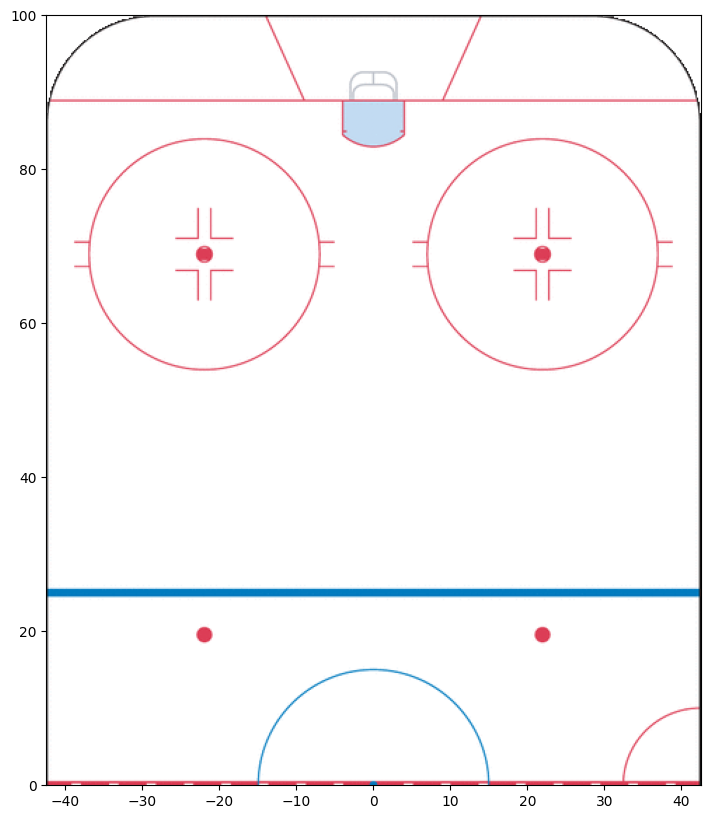

In [ ]:
plt.figure(figsize = (10,10))
img = mpimg.imread("./figures/nhl_rink.png")
(h, w, c) = img.shape
img_half = img[:, int(w/2):, :]

rink_img = ndimage.rotate(img_half, 90)

# The goal is located 11 inches from the end of the rink
# The middle line is (100-11) 89 inches from the goal
# plt.imshow(rink_img, extent=[-42.5, 42.5, 89, -11])
plt.imshow(rink_img, extent=[-42.5, 42.5, 0, 100])